In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Question 3:
Dataset used: Forest Fires

URL: https://archive.ics.uci.edu/dataset/162/forest+fires

In [11]:
# Reading in the data
filepath = 'forestfires.csv'
with open(filepath) as f:
    data = []
    f.readline() # Skip the first line.
    month_map = {'jan': 0,
                'feb': 1,
                'mar': 2,
                'apr': 3,
                'may': 4,
                'jun': 5,
                'jul': 6,
                'aug': 7,
                'sep': 8,
                'oct': 9,
                'nov': 10,
                'dec': 11}
    day_map = {'sun': 0,
               'mon': 1,
               'tue': 2,
               'wed': 3,
               'thu': 4,
               'fri': 5,
               'sat': 6}
    for line in f:
        curr_line = line.strip().split(',')
        curr_line[2] = month_map[curr_line[2]]
        curr_line[3] = day_map[curr_line[3]]
        curr_line = curr_line[:2] + curr_line[4:]
        data.append([float(x) for x in curr_line])

data = np.array(data)

x = data[:,:-1] # Features
y = data[:,-1] # Labels of the data
print(x.shape, y.shape)

(517, 10) (517,)


In [12]:
def CrossValidate(x, y, model, num_splits):
    """
    CrossValidate returns the root mean squared error of the cross validation.
    Input:
    x,y: Feature and label matrices
    model: Model used to predict
    num_splits: number of splits to use for cross fold validation.
    """
    cv_err = []
    r = x.shape[0]
    for i in range(num_splits):
        start = r//num_splits*i
        if i == num_splits-1:
            stop = r
        else:
            stop = r//5*(i+1)
        cv_train_x = x[start:stop]
        cv_train_y = y[start:stop]
        cv_test_x = np.concatenate((x[:start], x[stop:]), axis = 0)
        cv_test_y = np.concatenate((y[:start], y[stop:]), axis = 0)
            
        passive_model = model.fit(cv_train_x, cv_train_y)
        pred_y = passive_model.predict(cv_test_x)
        cv_err.append(root_mean_squared_error(cv_test_y, pred_y))
    
    return np.mean(cv_err)

# Question 3:
def Question3(x, y, seed=2024):
    N,k = x.shape

    # Shuffling the data to get a random starting set of training and testing data.

    gen = np.random.default_rng(seed)
    indexes = list(range(N))
    gen.shuffle(indexes)

    shuffled_x = x.copy()
    shuffled_y = y.copy()
    
    shuffled_x = shuffled_x[indexes]
    shuffled_y = shuffled_y[indexes]

    train_x, test_x = shuffled_x[:N//5], shuffled_x[N//5:]
    train_y, test_y = shuffled_y[:N//5], shuffled_y[N//5:]

    # Passive Learning
    model = make_pipeline(StandardScaler(), LinearRegression())
   
    passive_err_log = []
    passive_cross_val_log = []
    for i in tqdm(range(N//2-N//5)): # Range N//2-N//5 times to add points until half the data set.
        passive_cross_val_log.append(CrossValidate(train_x, train_y, model, 5)) 
        
        # Adding a random point from the testing dataset to the training dataset.
        train_x = np.concatenate((train_x,test_x[0:1]), axis = 0)
        train_y = np.concatenate((train_y,test_y[0:1]), axis = 0)
        test_x = test_x[1:]
        test_y = test_y[1:]

        # Training the model on the new train dataset.
        passive_model = model.fit(train_x, train_y)
        pred_y = passive_model.predict(test_x)
        passive_err_log.append(root_mean_squared_error(test_y, pred_y))


    train_x, test_x = shuffled_x[:N//5], shuffled_x[N//5:]
    train_y, test_y = shuffled_y[:N//5], shuffled_y[N//5:]

    # Active Learning
    model = make_pipeline(StandardScaler(), LinearRegression())

    active_err_log = []
    active_cross_val_log = []
    for i in tqdm(range(N//2-N//5)):
        active_cross_val_log.append(CrossValidate(train_x, train_y, model, 5))

        active_model = model.fit(train_x, train_y)

        # Uncertainty Sampling: Find highest variance data point from training data.
        pred_y = active_model.predict(test_x)
        sigma_squared = np.sum(np.power((test_y - pred_y),2))/(test_y.shape[0]-2)
        cov_mat = np.linalg.pinv(train_x.T@train_x)
        var = sigma_squared*np.sum((test_x@cov_mat)*test_x, axis = 1) # Calculating the variance of each y point.
        max_var_idx = np.argmax(var)

        # Move the data point of interest from the test set to the training set. 
        mask = np.ones(test_x.shape[0], dtype=bool)
        mask[max_var_idx] = False
        train_x = np.concatenate((train_x, test_x[max_var_idx:max_var_idx+1]), axis = 0)
        train_y = np.concatenate((train_y, test_y[max_var_idx:max_var_idx+1]), axis = 0)
        test_x = test_x[mask,...]
        test_y = test_y[mask,...]

        active_model = model.fit(train_x, train_y)
        pred_y = active_model.predict(test_x)
        active_err_log.append(root_mean_squared_error(test_y, pred_y))
            
    return passive_cross_val_log, passive_err_log, active_cross_val_log, active_err_log
        


In [13]:
# Running the simulation 5 times
for i in range(5):
    a,b,c,d = Question3(x,y,i*7331)
    if i == 0:
        passive_cv_log = np.array(a)[np.newaxis, :]
        passive_log = np.array(b)[np.newaxis, :]
        active_cv_log = np.array(c)[np.newaxis, :]
        active_log = np.array(d)[np.newaxis, :]
    else:
        passive_cv_log = np.concatenate((passive_cv_log, np.array(a)[np.newaxis, :]), axis = 0)
        passive_log = np.concatenate((passive_log, np.array(b)[np.newaxis, :]), axis = 0)
        active_cv_log = np.concatenate((active_cv_log, np.array(c)[np.newaxis, :]), axis = 0)
        active_log = np.concatenate((active_log, np.array(d)[np.newaxis, :]), axis = 0)

100%|██████████| 155/155 [00:01<00:00, 129.90it/s]


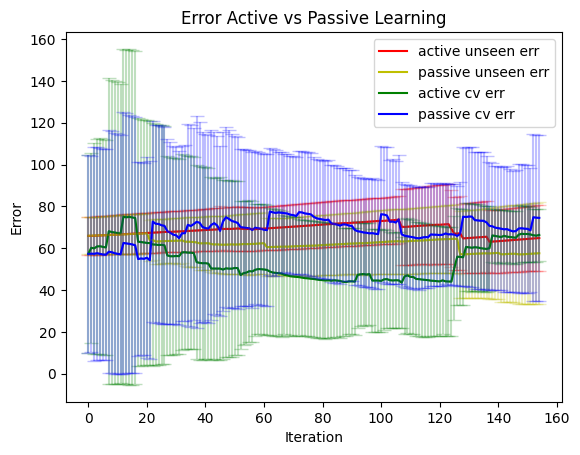

In [14]:
# Plotting the graph
fig, ax = plt.subplots(1)
labels = ['active unseen err', 'passive unseen err', 'active cv err', 'passive cv err']
plot_datas = [active_log, passive_log, active_cv_log, passive_cv_log]
colors = ['r','y','g','b']
handles = []
for i in range(4):
    plot_data = plot_datas[i]
    plot_y = np.mean(plot_data, axis = 0)
    plot_x = np.arange(plot_y.shape[0])
    yerr = np.std(plot_data, axis = 0)
    handle, = ax.plot(plot_x,plot_y, label = labels[i], color = colors[i])
    ax.errorbar(plot_x,plot_y,yerr, alpha = 0.25, color = colors[i], capsize = 5)
    handles.append(handle)
ax.legend(handles = handles)
ax.set_ylabel('Error')
ax.set_xlabel('Iteration')
ax.set_title('Error Active vs Passive Learning')
plt.show(fig)